<img src="./images/Logos.jpg" title="Institutional Logos" width="70%">

# Heat Waves | Uncertainty and Sensitivity 03: Integration Test of CLIMADA Impact Assessment with Copernicus Climate Change Service (C3S) data (V3)

### About

In this Jupyter Notebook, we delve into integrating CLIMADA's impact assessment capabilities with the heatwave datasets provided by the Copernicus Climate Change Service (C3S). We focus on unpacking the uncertainties and sensitivities within European heatwave data under the RCP 8.5 climate scenario. Utilizing CLIMADA's Unsequa module, we explore various SALib sampling techniques to quantitatively ascertain the uncertainties inherent in each component of the impact model and evaluate the sensitivity of these components, thereby enhancing the precision and reliability of climate impact assessments.

### About U-CLIMADAPT

The U-CLIMADAPT project is a collaborative effort led by the Working Group "Impact of Climate Change." Its primary goal is to provide refined climate impact assessments tailored to specific requirements. To achieve this, it leverages the power of climate forecasts and projections from C3S's Climate Data Store (CDS) while also integrating Copernicus land-use and satellite data

### Integrating CLIMADA and Copernicus Data

U-CLIMADAPT integrates Copernicus Climate Data Store (CDS) datasets with CLIMADA to create a powerful tool for assessing the socioeconomic impacts of climate hazards. By combining Copernicus data on extreme heat, floods, drought, and more with CLIMADA’s modeling capabilities, users can estimate risks to populations, infrastructure, and assets, enabling data-driven climate adaptation strategies.

### Tutorial Overview

Now, let's dive into the tutorial itself. We will guide you through the following steps:

- Define uncertain input parameters using the Unsequa module and set up the sensitivity analysis.
- Run Monte Carlo simulations to explore the effects of input uncertainties on model outputs.
- Analyze the results to quantify uncertainty and determine the most influential parameters through sensitivity analysis.

By following this tutorial, you will gain hands-on experience and unlock the potential of integrating CLIMADA with C3S data from Copernicus. Let's get started!

>**Important:** To learn more about the calculation of uncertainty and sensitivity in CLIMADA, please consult the [Unsequa](https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_unsequa.html) documentation on CLIMADA's website. For additional information in [Kropf, C.M. et al. (2021)](https://eartharxiv.org/repository/view/3123/)

<br>

### Acknowledgments

- **Script Author**: [Dahyann Araya](https://github.com/DahyannAraya?tab=repositories)
- **Reviewer**: [Tat Chi Wong](https://github.com/wongtaeth)

### Import libraries

We will be working with data in NetCDF format. To best handle this data, we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data; in this case, we will use Matplotlib and Cartopy.

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature


# Disable warnings for data download via API
import urllib3

urllib3.disable_warnings()
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely.predicates")
warnings.filterwarnings(
    "ignore", category=RuntimeWarning, module="shapely.constructive"
)

In [2]:
from climada import CONFIG

KEY = str(CONFIG.cds_api_key)

Here, we specify a data directory in which we will download our data and all output files that we will generate:

In [3]:
import os

# Set the data directory within the user's Documents directory
DATADIR = os.path.join(os.path.expanduser("~/Documents"), "test_data")
os.makedirs(DATADIR, exist_ok=True)
print(f"Data will be saved in: {DATADIR}")

Data will be saved in: /Users/daraya/Documents/test_data


In [4]:
current_directory = os.getcwd()

# Print the current directory
print("Current Directory:", current_directory)

Current Directory: /Users/daraya/Documents/GitHub_files/CDS_Warm_up/CDS_Warm_Up


# Set a heat wave hazard 

In this first exercise, our goal is to analyze the heatwave hazard in Europe using the [heatwave days dataset from Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview). The dataset provides information for different future periods and considers climate change scenarios, specifically RCP 8.5 and 4.6.

A bias-adjusted EURO-CORDEX dataset offers temperature data from 1971 to 2100. By averaging the statistics over 30-year intervals, a smoothed mean time series spanning 1986 to 2085 is obtained. The dataset provides annual heatwave days data with a resolution of 0.1° in latitude and longitude, equivalent to approximately 11 kilometers at the equator.

This exercise aims to provide insights into long-term heatwave trends in Europe, considering future projections and climate change scenarios. This analysis can contribute to a better understanding of the potential impacts of heatwaves on the region and inform relevant mitigation and adaptation strategies.

### Inspect data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data, we will use the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open-source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [49]:
import tarfile

tar_file = f"{DATADIR}/sis-heat-and-cold-spells.tar.gz"

# Print files names and extract
with tarfile.open(tar_file, "r:gz") as file:
    print(file.getnames())
    file.extractall(DATADIR)

# file.close()

['HWD_EU_health_rcp85_mean_v1.0.nc']


In [50]:
hwd_eu_rcp85_mean = f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc"
ds = xr.open_dataset(hwd_eu_rcp85_mean)
ds

<xarray.Dataset> Size: 102MB
Dimensions:        (lat: 425, lon: 599, time: 100)
Coordinates:
    height         float64 8B ...
  * lat            (lat) float64 3kB 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon            (lon) float64 5kB -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time           (time) datetime64[ns] 800B 1986-01-01 ... 2085-01-01
Data variables:
    HWD_EU_health  (time, lat, lon) float32 102MB ...
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 12:30:06 2019
    institution:    VITO (https://vito.be/en)

In [51]:
hwd_eu_rcp85_mean = ds["HWD_EU_health"]  # Extract variable

In [52]:
# Shape and sizes
print(hwd_eu_rcp85_mean.shape)
print(hwd_eu_rcp85_mean.size)

(100, 425, 599)
25457500


Please take a look below at what the annual heatwave days look like in 2010 and 2080. We can see that under this RCP8.5 scenario, heatwave days increased from 18 days per year in 2010 in the territory under study to a maximum of 80 days in 2080.

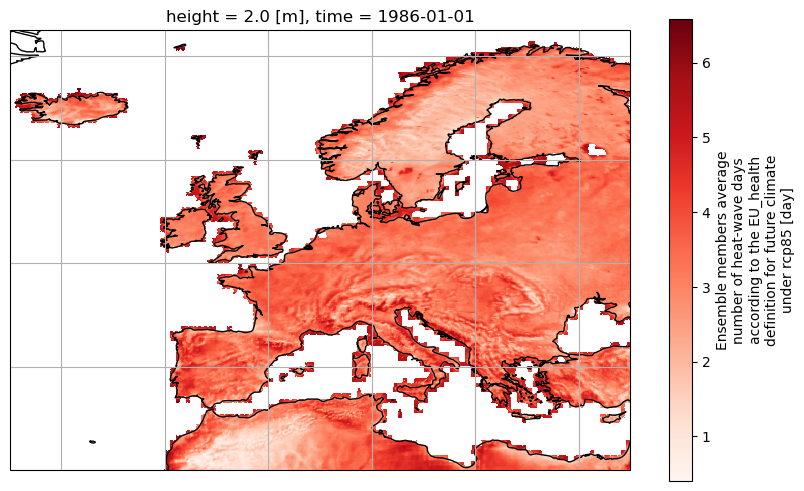

In [53]:
import cartopy.crs as ccrs

# Heat waves days in 2010
# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": proj})

# Plot the data isel() method
hwd_eu_rcp85_mean.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds")

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()
plt.show()

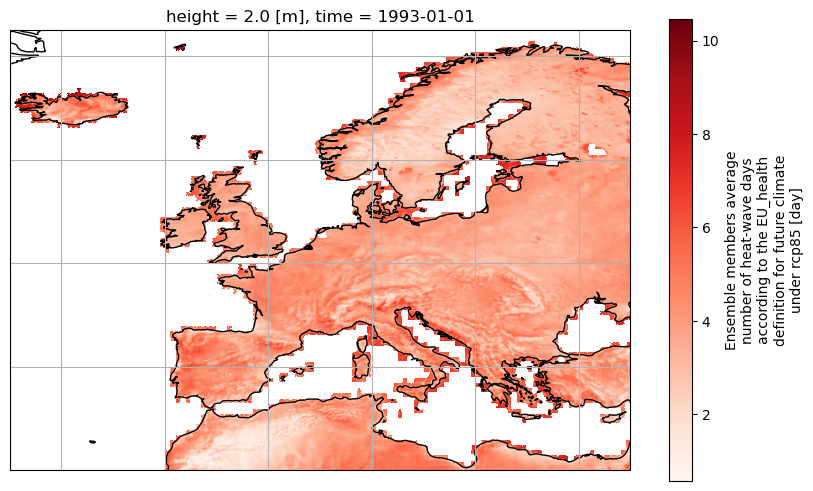

In [54]:
# Heat waves days in 2080

# Set projection to PlateCarree EPSG:4326
proj = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": proj})

# Plot the data isel() method
hwd_eu_rcp85_mean.isel(time=7).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds")

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

The histogram shows a distribution of hazard intensity values across the dataset. Most values are clustered around the lower end of the scale, with a long tail extending towards higher intensities.

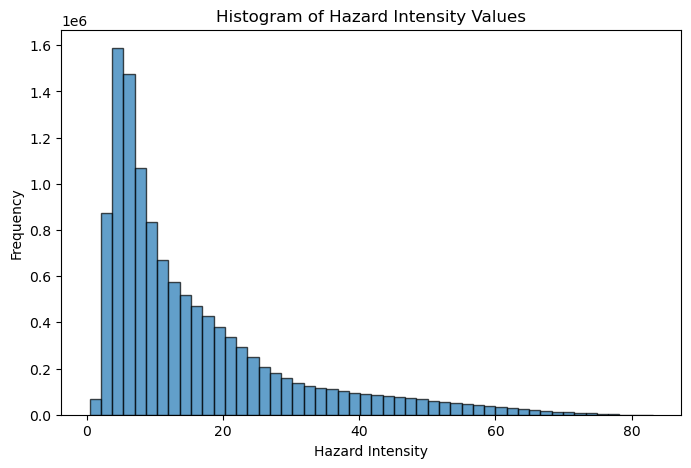

/var/folders/c5/1zdvytg95sl1p433qzv9t7lc0000gq/T/ipykernel_57604/2357093763.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hazard_data, shade=True)


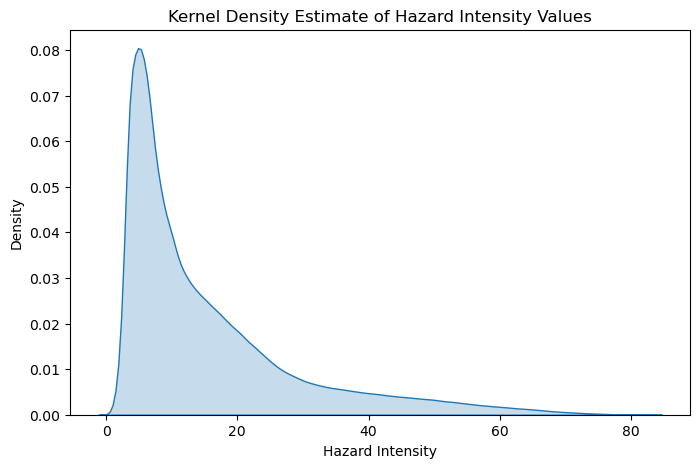

In [55]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the array and remove NaN values
hazard_data = ds['HWD_EU_health'].values.flatten()
hazard_data = hazard_data[~np.isnan(hazard_data)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(hazard_data, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histogram of Hazard Intensity Values")
plt.xlabel("Hazard Intensity")
plt.ylabel("Frequency")
plt.show()

# Plot KDE (Kernel Density Estimate)
plt.figure(figsize=(8, 5))
sns.kdeplot(hazard_data, shade=True)
plt.title("Kernel Density Estimate of Hazard Intensity Values")
plt.xlabel("Hazard Intensity")
plt.ylabel("Density")
plt.show()

We can extend this simple analysis into an empirical approach to calculate the return period. Here, we define thresholds every ten days, and the code counts how many times each threshold is exceeded in the entire dataset. It then calculates the frequency of exceedance by dividing the number of exceedances by the total number of data points. The return period is computed as the inverse of this frequency (1 / frequency). 

Interpretation of results:

- A return period of X years for a threshold Y means that, on average, the number of heat wave days is expected to exceed Y once every X years.
- Shorter return periods for higher thresholds indicate more frequent severe heat waves.
- The results show increasing return periods for higher thresholds, as expected.
- For example, a 10-day heat wave might have a return period of about four years, while an 80-day heat wave has a much more extended return period of over 300,000 years.

These results provide insights into the frequency and severity of heat waves projected under the RCP 8.5 scenario. They help in starting to understand the potential future climate risks and can inform adaptation strategies and impact assessments. The analysis also reveals the non-linear nature of extreme events, with very long return periods for the most severe heat waves. This empirical return period calculation differs from the return period calculation made on the future hazard object calculated with CLIMADA, since this is a simple threshold-based approach that doesn't account for spatial variations or more complex statistical distributions used in CLIMADA's calculations.


Data variable statistics:
Minimum value: 0.40221068263053894
Maximum value: 83.17239379882812
Mean value: 15.595580101013184
Standard deviation: 13.627824783325195

Number of NaN values: 13466800 out of 25457500 (52.90%)

Return periods for different thresholds:
Threshold 10 days/year: 1.92 years
Threshold 20 days/year: 3.87 years
Threshold 30 days/year: 7.33 years
Threshold 40 days/year: 12.84 years
Threshold 50 days/year: 26.12 years
Threshold 60 days/year: 72.29 years
Threshold 70 days/year: 407.87 years
Threshold 80 days/year: 142746.43 years


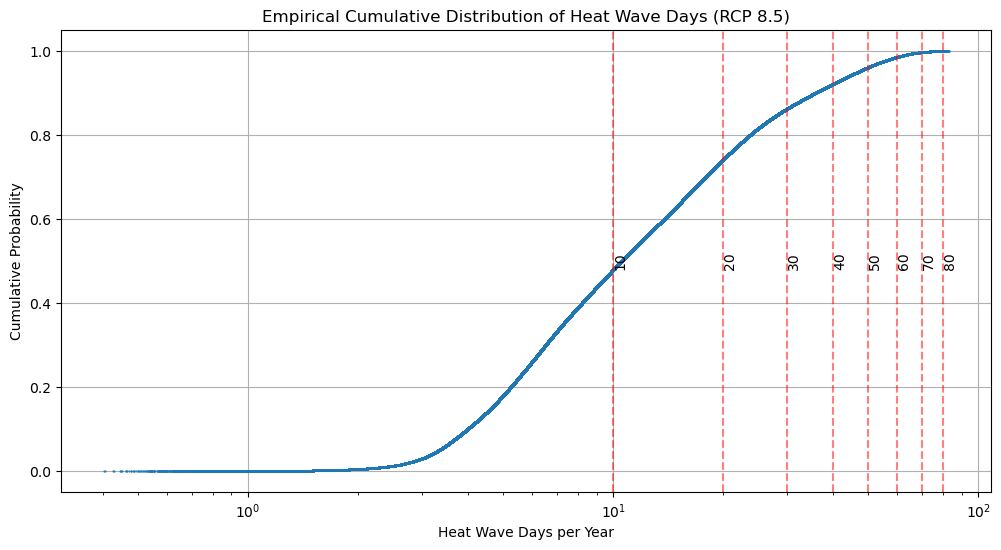

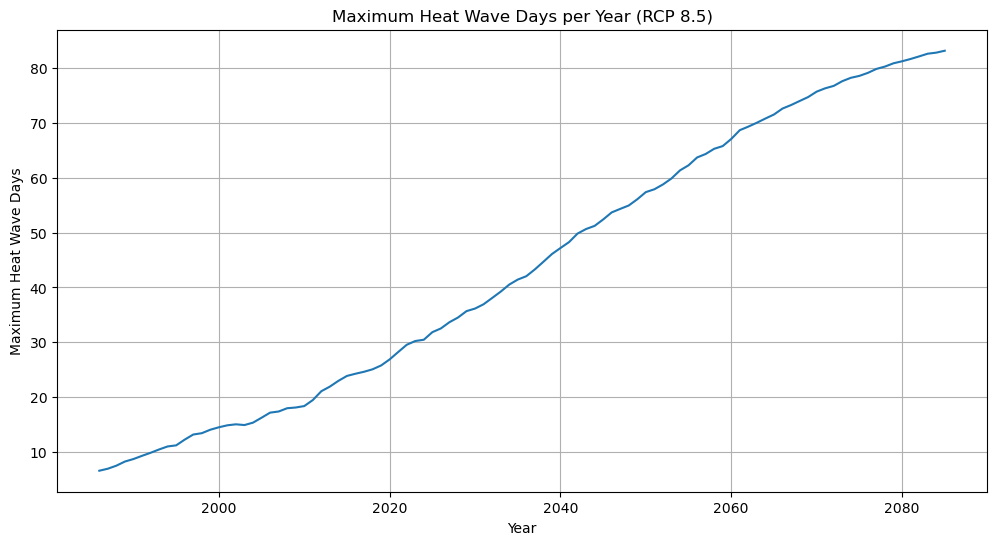


Maximum heat wave days in the entire dataset: 83.17
95th percentile of heat wave days: 46.64
99th percentile of heat wave days: 62.42


In [12]:
# Print basic statistics about the HWD_EU_health variable
print("\nData variable statistics:")
hwd_data = ds['HWD_EU_health']
print(f"Minimum value: {hwd_data.min().values}")
print(f"Maximum value: {hwd_data.max().values}")
print(f"Mean value: {hwd_data.mean().values}")
print(f"Standard deviation: {hwd_data.std().values}")

# Check for NaN values
nan_count = np.isnan(hwd_data).sum().values
total_count = hwd_data.size
print(f"\nNumber of NaN values: {nan_count} out of {total_count} ({nan_count/total_count*100:.2f}%)")

# Remove NaN values for calculations
hwd_data_clean = hwd_data.values.flatten()
hwd_data_clean = hwd_data_clean[~np.isnan(hwd_data_clean)]

# Define thresholds of interest for calculating return periods
thresholds = [10, 20, 30, 40, 50, 60, 70, 80]

# Calculate total number of valid data points
total_points = len(hwd_data_clean)

# Initialize a dictionary to store return periods for each threshold
return_periods = {threshold: 0 for threshold in thresholds}

# Calculate return periods for each threshold
for threshold in thresholds:
    # Count exceedances across all dimensions
    exceedances = (hwd_data_clean >= threshold).sum()
    
    # Calculate frequency and return period
    frequency = exceedances / total_points
    return_period = 1 / frequency if frequency > 0 else np.inf
    
    return_periods[threshold] = return_period

# Display return periods
print("\nReturn periods for different thresholds:")
for threshold, rp in return_periods.items():
    print(f"Threshold {threshold} days/year: {rp:.2f} years")

# Calculate and plot the empirical cumulative distribution function (ECDF)
sorted_hwd = np.sort(hwd_data_clean)
y = np.arange(1, len(sorted_hwd) + 1) / len(sorted_hwd)

plt.figure(figsize=(12, 6))
plt.plot(sorted_hwd, y, marker='.', linestyle='none', markersize=1)
plt.xlabel('Heat Wave Days per Year')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution of Heat Wave Days (RCP 8.5)')
for threshold in thresholds:
    plt.axvline(x=threshold, color='r', linestyle='--', alpha=0.5)
    plt.text(threshold, 0.5, f'{threshold}', rotation=90, verticalalignment='center')
plt.xscale('log')  # Use log scale for x-axis to better visualize the distribution
plt.grid(True)
plt.show()

# Additional analysis: time series of maximum heat wave days
max_hwd_per_year = hwd_data.max(dim=['lat', 'lon'])

plt.figure(figsize=(12, 6))
plt.plot(ds['time'], max_hwd_per_year)
plt.xlabel('Year')
plt.ylabel('Maximum Heat Wave Days')
plt.title('Maximum Heat Wave Days per Year (RCP 8.5)')
plt.grid(True)
plt.show()

# Print statistics
print(f"\nMaximum heat wave days in the entire dataset: {np.max(hwd_data_clean):.2f}")
print(f"95th percentile of heat wave days: {np.percentile(hwd_data_clean, 95):.2f}")
print(f"99th percentile of heat wave days: {np.percentile(hwd_data_clean, 99):.2f}")

The spatial map of the mean hazard intensity over time shows the average hazard intensity at different locations. This helps in understanding the overall exposure of various regions to the hazard. At the same time, the spatial map of the standard deviation of hazard intensity over time indicates areas with higher variability in hazard intensity. Higher values are seen in some regions, suggesting that the hazard intensity varies more in these areas.

The maps show that there is significant spatial variability in both the mean and standard deviation of hazard intensity. This is important for the impact assessment as it indicates different levels of exposure and variability across the region.

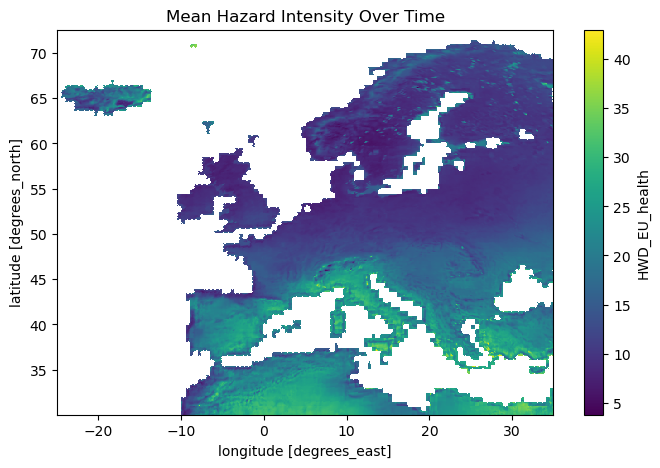

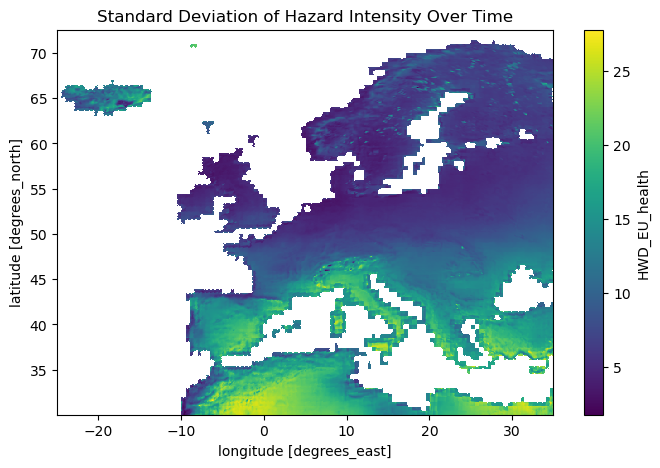

In [13]:
# Mean and standard deviation over time for each spatial point
mean_hazard = ds['HWD_EU_health'].mean(dim='time')
std_hazard = ds['HWD_EU_health'].std(dim='time')

# Plot spatial variability
plt.figure(figsize=(8, 5))
mean_hazard.plot()
plt.title("Mean Hazard Intensity Over Time")
plt.show()

plt.figure(figsize=(8, 5))
std_hazard.plot()
plt.title("Standard Deviation of Hazard Intensity Over Time")
plt.show()

# Unsequa Module

The Unsequa module in CLIMADA provides a comprehensive framework for conducting uncertainty and sensitivity analysis for various climate and disaster impact models. It allows users to define uncertain parameters through the InputVar class, perform Monte Carlo simulations, and analyze the impact of these uncertainties on the model's outputs.



Uncertainty measurement in the context of CLIMADA's Unsequa module and similar frameworks involves quantifying the variability or unpredictability in model outputs due to uncertain inputs. This process typically includes the following key steps:

- Identification of Uncertain Inputs: The first step involves identifying the uncertain input parameters of the model. These could be related to hazard characteristics (e.g., intensity or frequency of events), exposure values (e.g., asset values), vulnerability curves, or adaptation measures costs and effectiveness. In CLIMADA's Unsequa module, these inputs are encapsulated in the InputVar class.

- Defining Probability Distributions for Inputs: For each uncertain input, a probability distribution is assigned to describe the range and likelihood of its possible values. This distribution reflects the current understanding or best estimate of the variability of the input. Commonly used distributions include uniform, normal (Gaussian), beta, and log-normal distributions, which are chosen based on the nature of the input and available data.

- Sampling from Distributions: Sampling techniques are used to generate sets of input values from the defined probability distributions. These techniques include simple random sampling, Latin Hypercube Sampling (LHS), and more sophisticated methods like the Saltelli sampling method for Sobol' sensitivity analysis. The goal is to efficiently explore the input space to capture the effects of input uncertainties on the model outputs.

- Running the Model with Sampled Inputs: The model is run multiple times, each time with a different set of input values generated from the sampling process. This step produces a range of outputs corresponding to the variability in the inputs, allowing for the analysis of how input uncertainty propagates through the model.

- Analyzing the Output: The variability in the model outputs is then analyzed to quantify uncertainty. This can involve calculating statistical measures such as the mean, variance, or percentiles of the output distribution. Additionally, visualization techniques like histograms or probability density plots can help understand the distribution of the outputs.

- Sensitivity Analysis: To understand the contribution of each uncertain input to the output variability, sensitivity analysis is conducted. Methods like Sobol' sensitivity analysis can decompose the variance of the model output to attribute it to the variance in individual inputs or combinations of inputs. This helps identify the inputs that have the most significant impact on output uncertainty.

The Unsequa module in CLIMADA facilitates this process by providing structured classes (InputVar, CalcImpact, CalcDeltaImpact, CalcCostBenefit) and methods to define uncertain inputs, perform sampling, run simulations, and analyze the uncertainty and sensitivity of the outputs. This structured approach allows users to systematically quantify and understand the uncertainty in their risk assessments or cost-benefit analyses of adaptation measures, ultimately leading to more informed decision-making.

__Here are the key concepts and functionalities within the Unsequa module:__

a) Uncertainty and Sensitivity Analysis: Before using the module, it's crucial to understand the different types of uncertainties and their implications on modeling results. The module supports global uncertainty and sensitivity analysis, contrasting with the "one-factor-at-a-time" (OAT) method, which is less robust.

b) Unsequa Module Structure:

  - **InputVar**: Defines input uncertainty variables, which can be continuous or categorical. Users can specify a model variable as a function of uncertainty       input parameters and their probability distributions.
  - **CalcImpact**, **CalcDeltaImpact**, **CalcCostBenefit**: These classes calculate uncertainties for different outputs (e.g., impact, delta impact, cost-         benefit) using the defined InputVars.
  - **UncOutput**: Stores the results of uncertainty and sensitivity analysis, including the sampled data, calculated metrics, and sensitivity indices. It also          supports plotting methods for visualization.
    

c) Defining Uncertainty Variables (InputVar):

  - Uncertainty parameters are defined by specifying a function that returns a model variable and a dictionary of probability distributions for each input           parameter.
  - The module supports any probability distribution defined in scipy.stats.

d) Calculating Uncertainty and Sensitivity:

  - **The CalcImpact, CalcDeltaImpact, and CalcCostBenefit** classes are used to set input variables and compute uncertainty and sensitivity analysis.
        Users can specify non-default parameters for sampling methods, the number of samples, and sensitivity analysis methods to customize the analysis.

e) Visualization and Analysis:

  - **UncOutput** and its subclasses offer various plotting methods to visualize uncertainty distributions, sensitivity indices, and specific metrics like return periods or cost-benefit ratios.

>**Important:** To learn more about the calculation of uncertainty and sensitivity in CLIMADA, please consult the [Unsequa](https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_unsequa.html) documentation on CLIMADA's website. For additional information in [Kropf, C.M. et al. (2021)](https://eartharxiv.org/repository/view/3123/)

## Heat waves uncertainty and sensitivity analysis

This Jupyter tutorial focuses on understanding how uncertainty affects our model. While uncertainty can arise from various sources, such as exposure data, hazard data, parameter data, or the hazard model, here we will focus on the vulnerability function and exposure parameters.

In this context, we focus on calibrating the impacts of heatwaves and understanding the uncertainty and range of possible outcomes. As shown below, we specified uncertainties in the mean damage degree (MDD) and impact function intensity. To vividly illustrate these uncertainties, we introduced a sigmoid function that calculates MDD based on intensity, capturing the escalation of damage as heatwaves intensify. Subsequently, we used an impact function with similar parameters to those in the Warm-Up exercise. Next, we generated exposure data tied to uncertainties, utilizing the LitPop class for designated countries with 'population' as the value unit.

We then outlined functions and distributions to adjust exposures and vulnerabilities based on the identified uncertainties. This led to initiating a CalcImpact object, encapsulating the adjusted exposure and vulnerabilities alongside the hazard data. Finally, we showcased two sampling techniques, Latin and Saltelli, to generate samples of uncertainties. CLIMADA also offers several other sampling method alternatives that can be explored. Here is a brief explanation of them:

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Important: The dummy function and the uncertainty parameters added in this documentation allow for the analysis of the relationship between population and heatwave days. This function and parameters serve as a demonstration only; you should define your own functions according to your specific field of study. </div>

>**Important:** The sampling methods in Unsequa are part of the SALib library, a widely used library for conducting Sensitivity Analysis (SA) in scientific research. These methods are designed to efficiently sample the input space of a model to analyze how variations in model inputs contribute to changes in the output. Here's a brief explanation of each method:

>Saltelli: This method is an extension of the Sobol' sequence sampling, providing a way to estimate the total variance and Sobol sensitivity indices. It generates samples by systematically varying each input parameter, allowing for the estimation of both main effects and interaction effects among the parameters. It is particularly effective for global sensitivity analysis and is one of the most commonly used methods for variance-based sensitivity analysis.

>FAST Sampler (Fourier Amplitude Sensitivity Testing): The FAST method is a frequency domain analysis technique. It assesses sensitivity by transforming a time or space domain model into the frequency domain using Fourier transforms. It is beneficial for models with a large number of inputs, as it can efficiently compute first-order sensitivity indices with fewer model evaluations than some other methods.

>Latin Hypercube Sampling (LHS): LHS is a statistical method for generating a sample of plausible collections of parameter values from a multidimensional distribution. Efficiently covers the entire range of input variables by dividing each variable's range into intervals of equal probability. It ensures every part of the range is sampled without overlaps, which is beneficial for exploring the input space thoroughly with a relatively small number of samples.

>Morris Method: Also known as the Morris One-At-A-Time (OAT) method, this technique involves systematically and incrementally varying one input parameter at a time while keeping the others fixed to determine the effect of each parameter on the output. It's a qualitative method to identify non-linearities and interactions between parameters, providing measures of elementary effects that indicate parameter importance.

>DGSM (Derivative-based Global Sensitivity Measures): This approach uses the derivatives of the model output concerning its inputs to assess sensitivity. It's beneficial for identifying parameters that have a significant impact on the output across the entire input space, allowing for a quick screening of parameters to focus more detailed analysis on those that are most influential.

>FF (Fractional Factorial): This method involves running a subset of all possible combinations of parameter settings using a fraction of the full factorial design. It's a type of experimental design that can identify the most important factors and their interactions in models with a large number of inputs, reducing the total number of simulations required.

https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_unsequa.html#uncoutput
https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_unsequa_helper.html#impactfuncset

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Important: The dummy function used in this documentation allows for the analysis of the relationship between exposure and the hazard. This function and parameters serve as a demonstration only; you should define your own functions according to your specific field of study.
</div>

### Impact function:
The function `sigmoid_mdd` calculates the Mean Damage Degree (MDD) for a given hazard intensity using a sigmoid function. The sigmoid function is often used to model situations where the response (in this case, damage) gradually increases with the stimulus (hazard intensity).

### Parameters:
- **intensity**: The hazard intensity, which can vary over a range (e.g., from 0 to 365 days in the case of heatwaves).
- **T (Threshold)**: The intensity value where the sigmoid function inflects, meaning the point where the increase in MDD is most rapid. The default is 3.
- **k (Steepness)**: The steepness of the sigmoid curve. A larger value of `k` results in a steeper curve, meaning the transition from low to high MDD happens more abruptly. The default is 0.1.
- **maxMDD**: The maximum possible value of MDD. The default is 1, meaning the damage degree ranges from 0 to 1.

### Mathematical Expression:
The function uses the logistic (sigmoid) function, which is given by the formula:
$$
\text{MDD} = \frac{\text{maxMDD}}{1 + e^{-k \cdot (\text{intensity} - T)}}
$$

This formula describes an S-shaped curve that smoothly transitions from 0 to `maxMDD`.

### Application:
- When the intensity is much lower than the threshold `T`, the term $-k \cdot (\text{intensity} - T)$ is positive and large, making $e^{-k \cdot (\text{intensity} - T)}$ large. Thus, the MDD is close to 0.
- When the intensity is much higher than the threshold `T`, the term $-k \cdot (\text{intensity} - T)$ is negative and large, making $e^{-k \cdot (\text{intensity} - T)}$ small. Thus, the MDD approaches `maxMDD`.
- Around the threshold `T`, the function transitions smoothly from low to high values, with the steepness controlled by `k`.


It is important to note that frequency calculation methods can vary depending on the specific hazard type, data availability, and research objectives. CLIMADA is flexible and allows users to implement custom frequency calculation methods when needed.

Based on the CLIMADA documentation and typical practices in hazard risk modeling, frequency in CLIMADA is usually calculated as follows:

- For historical hazard data:
        Frequency is typically set as one divided by the number of years in the dataset.
        This assumes each historical event has an equal probability of occurrence.
- For synthetic hazard sets:
        Frequencies are often assigned based on the probability of occurrence for each synthetic event.
        The sum of all frequencies should equal 1 (representing one event per year on average).
- For climate change scenarios:
        Frequencies may be adjusted to reflect changing probabilities over time.
        This could involve trend analysis or more complex statistical methods.

For climate change scenarios like the RCP 8.5 data, CLIMADA allows for more sophisticated frequency calculations like the one we showcase here, a trend-adjusted approach. 



In [14]:
import numpy as np
import pandas as pd
from climada.hazard import Hazard
from climada.entity import ImpactFunc, ImpactFuncSet, LitPop
from climada.engine import Impact
from climada.engine.unsequa import InputVar, CalcImpact
import scipy.stats as stats  # Changed this line
import matplotlib.pyplot as plt
import time
import xarray as xr

# Define bounds for adding uncertainties
bounds_mdd = [0.7, 1.3]  # -30% to +30% uncertainty on the mdd
bounds_paa = None  # No uncertainty in the paa
bounds_impfi = [-10, 10]  # -10 to +10 uncertainty on the intensity

# Sigmoid function for MDD calculation
def sigmoid_mdd(intensity, T=3, k=0.1, maxMDD=1):
    """Calculates a sigmoid mean damage degree (MDD) based on intensity."""
    return maxMDD / (1 + np.exp(-k * (intensity - T)))

# Create the ImpactFuncSet object with sigmoid MDD
if_heatwave = ImpactFunc()
if_heatwave.haz_type = "Heat_waves_days"
if_heatwave.id = 1
if_heatwave.name = "Heat wave impact function"
if_heatwave.intensity_unit = "days"
if_heatwave.intensity = np.arange(0, 366, 1)
if_heatwave.mdd = sigmoid_mdd(if_heatwave.intensity)
if_heatwave.paa = np.ones(366)
if_set_base = ImpactFuncSet([if_heatwave])

# Load hazard data
hwd_eu_rcp85_mean = f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc"
ds = xr.open_dataset(hwd_eu_rcp85_mean)

# Convert time to pandas datetime format
times = pd.to_datetime(ds['time'].values)

# Calculate the total time period in years
total_time_period = (times[-1] - times[0]).days / 365.25

# Load hazard data into CLIMADA Hazard object
hazard = Hazard.from_xarray_raster_file(
    f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc",
    hazard_type="Heat_waves_days",
    intensity_unit="days",
    intensity="HWD_EU_health",
    coordinate_vars=dict(event="time", longitude="lon", latitude="lat"),
)
hazard.event_name = list(map(lambda x: pd.Timestamp(x).isoformat(), hazard.event_name))

# Extract years from the time dimension
years = pd.to_datetime(ds['time'].values).year

# Calculates the maximum heat wave days for each year across all locations
annual_max = ds['HWD_EU_health'].groupby('time.year').max(dim=['lat', 'lon'])

# Fit a linear trend to the annual maximum values
slope, intercept, r_value, p_value, std_err = stats.linregress(years, annual_max)

# Calculate the trend-adjusted frequencies
trend_adjusted_freq = (slope * years + intercept) / np.sum(slope * years + intercept)

# Convert to numpy array
trend_adjusted_freq = trend_adjusted_freq.values

#Assigning frequencies to the hazard object:
# The trend-adjusted frequencies are assigned to the hazard object. This replaces the original equal probabilities with probabilities that reflect the trend
hazard.frequency = trend_adjusted_freq

# Normalize frequencies to ensure they sum to 1
hazard.frequency /= hazard.frequency.sum()

print("Sum of adjusted hazard frequencies:", hazard.frequency.sum())

# Recalculate return periods using the adjusted hazard object
rps = [1, 10, 100]
intensities = hazard.local_exceedance_inten(rps)

print("\nAdjusted Return Period Hazard Intensities Across the Study Area:")
for rp, intensity in zip(rps, intensities):
    print(f"RP {rp} years:")
    print(f"  Min: {np.min(intensity):.2f} days")
    print(f"  Max: {np.max(intensity):.2f} days")
    print(f"  Mean: {np.mean(intensity):.2f} days")
    print(f"  Median: {np.median(intensity):.2f} days")
    print(f"  5th percentile: {np.percentile(intensity, 5):.2f} days")
    print(f"  95th percentile: {np.percentile(intensity, 95):.2f} days")



# Exposure
exp_base = LitPop.from_countries(
    ["CHE", "DEU"], res_arcsec=120, fin_mode="pop", exponents=(2, 1)
)
exp_base.assign_centroids(hazard)
exp_base.value_unit = "Population"

# Define functions to modify exposures and hazards based on uncertainty parameters
def exp_func(x_exp):
    exp = exp_base.copy()
    exp.gdf["value"] *= x_exp
    return exp

exp_distr = {
    "x_exp": stats.norm(1, 0.2)  # Normal distribution for hazard intensity scaling
}

# Add the impact function id to the exposures
[haz_type] = if_set_base.get_hazard_types()
[haz_id] = if_set_base.get_ids()[haz_type]
hazard_type = "Heat_waves_days"
exp_base.gdf["impf_" + hazard_type] = haz_id

# Create InputVar instances
exp_iv = InputVar(exp_func, exp_distr)



# Create the InputVar object for the vulnerability function with uncertainties
vuln_iv = InputVar.impfset(
    impf_set_list=[if_set_base],
    bounds_impfi=bounds_impfi,
    bounds_mdd=bounds_mdd,
    bounds_paa=bounds_paa,
    haz_id_dict={"Heat_waves_days": [1]},
)

# Initialize CalcImpact object for uncertainty analysis with adjusted exposure
calc_imp = CalcImpact(exp_iv, vuln_iv, hazard)

# Generate samples and calculate impacts with uncertainty
sample_output_imp_non_linear = calc_imp.make_sample(N=2**10, sampling_method="saltelli")

# Compute the eai_exp metric distribution
start = time.time()
output_imp_non_linear = calc_imp.uncertainty(
    sample_output_imp_non_linear,
    rp=[1, 10, 100],
    calc_eai_exp=True,
    calc_at_event=True,
    processes=4,
)
end = time.time()

time_passed = end - start
print(f"Time passed with pool: {time_passed}")
# Print the results of the uncertainty analysis
print("\nUncertainty analysis results:")
print(output_imp_non_linear)

Sum of adjusted hazard frequencies: 1.0

Adjusted Return Period Hazard Intensities Across the Study Area:
RP 1 years:
  Min: 0.00 days
  Max: 32.19 days
  Mean: 6.17 days
  Median: 0.00 days
  5th percentile: 0.00 days
  95th percentile: 18.58 days
RP 10 years:
  Min: 0.00 days
  Max: 88.07 days
  Mean: 16.88 days
  Median: 0.00 days
  5th percentile: 0.00 days
  95th percentile: 61.38 days
RP 100 years:
  Min: 0.00 days
  Max: 144.13 days
  Mean: 27.58 days
  Median: 0.00 days
  5th percentile: 0.00 days
  95th percentile: 104.31 days
2024-08-24 17:44:11,138 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 17:44:11,147 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 17:44:11,156 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data

The image displays the original impact function for heatwaves for 50 random samples. The impact function is plotted with the mean damage degree (MDD) and the potentially affected area (PAA). The blue line represents the original MDD, while the red line shows the original PAA.

The grey lines represent the MDD of 50 samples, each generated by varying the MDD and the intensity of the heat waves within a range (the bounds of uncertainty). These modifications simulate how different assumptions within the specified uncertainty bounds can affect the impact function. The wide spread of grey lines illustrates the potential variability in the impact due to changes in MDD and intensity shift, emphasizing the range of possible outcomes when factoring in uncertainties.

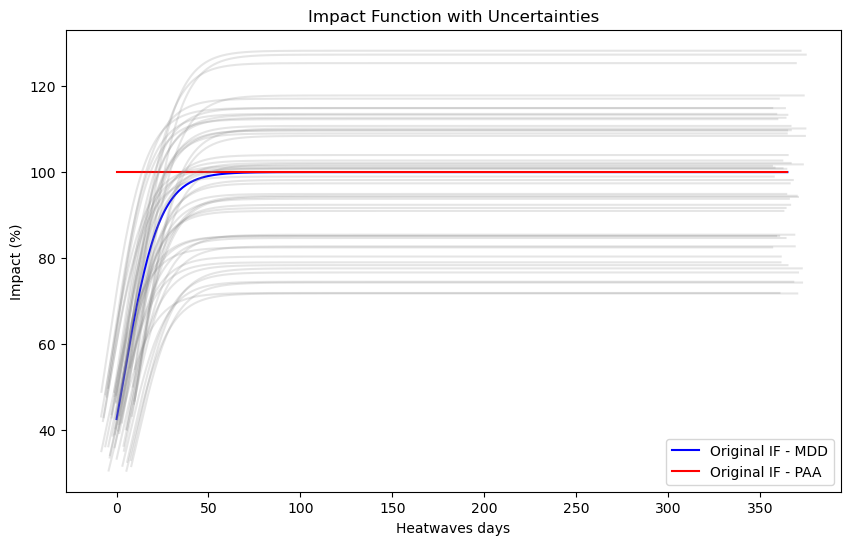

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from climada.entity import ImpactFunc

# Number of samples to generate
n = 50

# Plot the original impact function
fig, ax = plt.subplots(figsize=(10, 6))

# Manually plot the MDD and PAA for the original impact function
ax.plot(if_heatwave.intensity, if_heatwave.mdd * 100, "b", label="Original IF - MDD")
ax.plot(if_heatwave.intensity, if_heatwave.paa * 100, "r", label="Original IF - PAA")

# Generate and plot n modified impact functions
for _ in range(n):
    # Randomly sample mdd_factor and intensity_shift within their bounds
    mdd_factor = np.random.uniform(bounds_mdd[0], bounds_mdd[1])
    intensity_shift = np.random.uniform(bounds_impfi[0], bounds_impfi[1])

    # Apply the random samples to modify the base impact function
    modified_intensity = if_heatwave.intensity + intensity_shift
    modified_mdd = if_heatwave.mdd * mdd_factor

    # Plot the modified MDD curve with low opacity
    ax.plot(
        modified_intensity,
        modified_mdd * 100,
        color="grey",
        alpha=0.2,
        label="_nolegend_",
    )

# Enhance plot
ax.set_xlabel("Heatwaves " + if_heatwave.intensity_unit)
ax.set_ylabel("Impact (%)")
ax.set_title("Impact Function with Uncertainties")
ax.legend()

# Show the plot
plt.show()

### Explore Uncertainty

<div class="alert alert-block alert-warning"> <i class="fa fa-warning"></i>&nbsp;Important: The results of the uncertainty analysis may vary between runs due to the use of Saltelli sampling. This stochastic method ensures a comprehensive exploration of parameter space but can lead to slight differences in outcomes across multiple code executions. </div>

Here, it can be seen that the output includes the Aggregated Annual Impact (aai_agg), the Frequency Curve, and the information per event as At_Event.

In [16]:
# All the computed uncertainty metrics attribute
output_imp_non_linear.uncertainty_metrics

['aai_agg', 'freq_curve', 'eai_exp', 'at_event']

The get_uncertainty() method summarises the analysis of how uncertainties in the input parameters influence the model's outputs. 
- aai_agg (Annual Aggregated Impact)
- Return period columns: `rp1`, `rp10`, and `rp100` (1-year, 10-year, and 100-year return periods)
- Columns 0 to 99, corresponding to at_event data for individual events

Each row represents a different sample scenario, showing the range of possible outcomes due to input uncertainties. The values demonstrate variability in the Estimated annual aggregated impact (aai_agg), Expected damages for specific return periods (`rp1`, `rp10`, `rp100`) and Impact of individual events (columns 0 to 99).

For example, aai_agg values range from ≈ 20 million to ≈ 60 million, indicating significant uncertainty in annual impact estimates. Impact values generally increase with the return period (`rp1` < `rp10` < `rp100`), as expected for more extreme events. The at_event data (columns 0 to 99) will be used later to plot sensitivity analysis, providing insights into how individual events contribute to overall uncertainty. 

The hazard intensity shape (100, 254575) indicates 100 events or time steps and 254,575 spatial points or grid cells, showing the spatial and temporal resolution of the hazard data used in the analysis.

In [17]:
print(output_imp_non_linear.get_uncertainty())
np.shape(hazard.intensity)

           aai_agg           rp1          rp10         rp100         0  \
0     2.658837e+07  1.964003e+07  3.060714e+07  3.088153e+07  0.013687   
1     6.521698e+07  4.817383e+07  7.507437e+07  7.574742e+07  0.033572   
2     2.440754e+07  1.657366e+07  2.930316e+07  2.966374e+07  0.012882   
3     3.223154e+07  2.446341e+07  3.528730e+07  3.529485e+07  0.015912   
4     2.993387e+07  2.064398e+07  3.491624e+07  3.508447e+07  0.015199   
...            ...           ...           ...           ...       ...   
8187  2.227497e+07  1.462910e+07  2.714580e+07  2.747823e+07  0.011831   
8188  2.223746e+07  1.458468e+07  2.712192e+07  2.745645e+07  0.011818   
8189  6.040403e+07  3.967039e+07  7.361251e+07  7.451395e+07  0.032083   
8190  6.792310e+07  4.547766e+07  7.989938e+07  8.015500e+07  0.034535   
8191  6.030233e+07  3.954993e+07  7.354775e+07  7.445491e+07  0.032048   

             1         2         3         4         5  ...            90  \
0     0.033615  0.151561  0.015099

(100, 254575)

In [18]:
# One uncertainty dataframe
output_imp_non_linear.get_unc_df("aai_agg").tail()

,aai_agg
8187,2.227497e+07
8188,2.223746e+07
8189,6.040403e+07
8190,6.792310e+07
8191,6.030233e+07


Output_imp_non_linear.plot_uncertainty visually represents the Annual Aggregated Impact (aai_agg) distribution from your uncertainty analysis. The resulting plot helps you interpret the range and likelihood of different impact scenarios:

Plot components:
- X-axis shows aai_agg values in millions of affected people
- Y-axis represents the density or frequency of these values
- Histogram bars display how often specific impact levels occur
- Blue curve (KDE) smooths out the distribution for a more straightforward interpretation
- Orange dashed line marks the average impact
- Black line indicates one standard deviation from the mean

The plot shows         
- Distribution Shape: The shape of the distribution suggests that while most years experience a typical level of heatwave impact (centered around the average), there are some years where significantly fewer or more people are affected. The slight skew suggests that extreme years (either very low or very high impacts) are less common but possible.
- Mean (avg ≈ 63M): The average impact across all years is ≈ 63M million people affected by heatwaves annually. This gives you a sense of what the "typical" year looks like regarding population impact.
- Standard Deviation (std≈18M): The standard deviation shows that the number of people affected by heatwaves can vary widely from the average. In some years, the impact could be much lower or higher than the average of ≈ 62 million, reflecting variability in heatwave severity and population vulnerability.
- Uncertainty Representation: The range and width of the distribution highlight the uncertainty and variability in heatwave impacts over time. A wider distribution indicates that the number of people affected can fluctuate significantly from year to year, depending on various factors such as changes in heatwave intensity, duration, and population growth or adaptation measures.

This analysis helps you understand how the impact of heatwaves on the population has varied historically and how it might continue to vary in the future. It also emphasizes the importance of considering both average impacts and the range of potential outcomes when planning for heatwave responses.

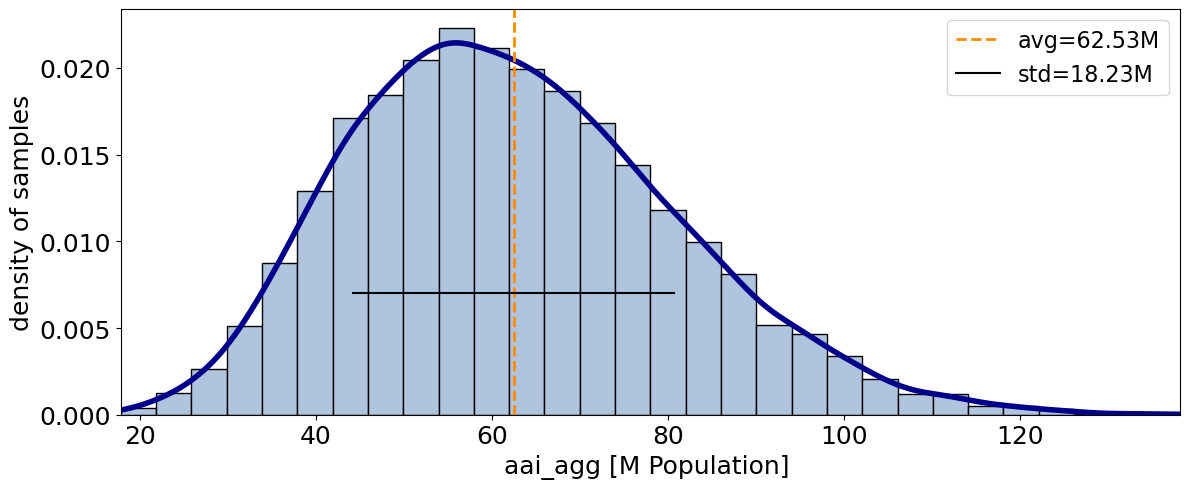

In [19]:
# Range of aai_agg
output_imp_non_linear.plot_uncertainty(metric_list=["aai_agg"], figsize=(12, 5));

We can examine samples of uncertainty parameters or plot them, starting with 
- **x_exp**, the scaling factor that adjusts exposure values, signifying the degree to which original values are either amplified or diminished.
- Following this, **IFi** represents modifications to the intensity of the impact function, capturing the alterations in damage estimations resulting from fluctuating hazard intensities.
- Lastly, **MDD**, or Mean Damage Degree, is a measure denoting the average damage at a given intensity level of the hazard.

This output shows the last five rows of samples generated for the uncertainty analysis. Each row represents a different scenario with specific values for three key parameters:

1. x_exp (Exposure Scaling Factor):
   - For example, a range: ≈0.3 to ≈0.9
   - This factor adjusts exposure values. Values <1 reduce exposure, while >1 increase it.
   - For example, ≈0.3 means exposure is reduced to about 30% of the original value, while ≈0.9 means it's at about 90%.

2. IFi (Impact Function Intensity Modifier):
   - For example, a range: ≈2.55 or ≈2.61
   - This modifies impact function intensity. Values >1 increase the estimated impact for a given hazard intensity.
   - Both values suggest a significant increase in impact intensity, more than doubling original estimates.

3. MDD (Mean Damage Degree):
   - For example, a range: ≈1.09 or ≈1.26
   - Represents average damage at a given hazard intensity level.
   - Values above 1 indicate a slight increase in estimated damage compared to baseline.


Interpretation:

a) Samples show various parameter combinations used in uncertainty analysis.  
b) Exposure scaling (x_exp) varies widely, from significant reduction to near-original values.  
c) Impact function intensity (IFi) consistently increases, testing higher impact scenarios.  
d) Mean Damage Degree (MDD) is slightly increased in all samples, with one scenario showing a more substantial increase.  

These variations explore a range of outcomes, from less severe scenarios (low exposure, lower MDD) to more extreme ones (higher exposure, higher IFi and MDD), helping understand potential impacts and model sensitivity.

In [20]:
# Print sample of the tail results
output_imp_non_linear.get_samples_df().tail()

,x_exp,IFi,MDD
8187,0.340561,2.548828,1.094629
8188,0.340561,2.607422,1.094629
8189,0.923516,2.548828,1.094629
8190,0.923516,2.607422,1.258691
8191,0.923516,2.607422,1.094629


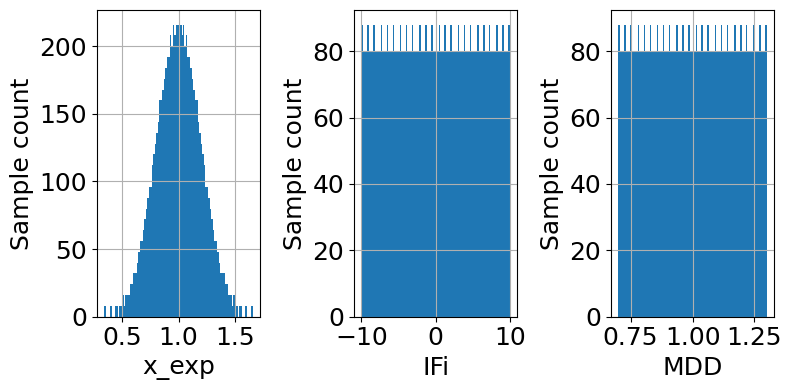

In [21]:
output_imp_non_linear.plot_sample(figsize=(8, 4));

Below, we plot four distribution plots, each representing the uncertainty in the predicted impact of heatwaves on the population:

- The first plot (top left) represents the mean annual impact (`aai_agg`), with a mean impact (avg) of ≈63 million people (the dashed vertical lines in each graph represent the mean values, visually indicating the center of the distributions) and a standard deviation (std) of ≈18 million. The distribution appears normal around the mean, indicating that most of the simulations cluster around this central value with a dispersion dictated by the standard deviation.

- The second graph (top right) illustrates the 1-year return period (`rp1`), showing a mean impact on ≈47 million people with a standard deviation of ≈16 million. This graph suggests a similar dispersion of results as the first, with most of the results close to the mean value.

- The third graph (bottom left) shows the 10-year return period (`rp10`), with a mean of ≈73 million people affected and a standard deviation of ≈19 million. This suggests a slightly higher average impact than `rp1`, possibly indicating that more extreme events occurring less frequently may affect more people.

- The fourth graph (bottom right) presents the 100-year return period (`rp100`), with a mean of ≈74 million people affected and a standard deviation of ≈19 million. Like `rp10`, it reflects the results of less frequent but more severe events.

#### Return Periods and Aggregated Annual Impact (aai)
<a id="output-return-periods-and-aggregated-annual-impact-aai"></a>



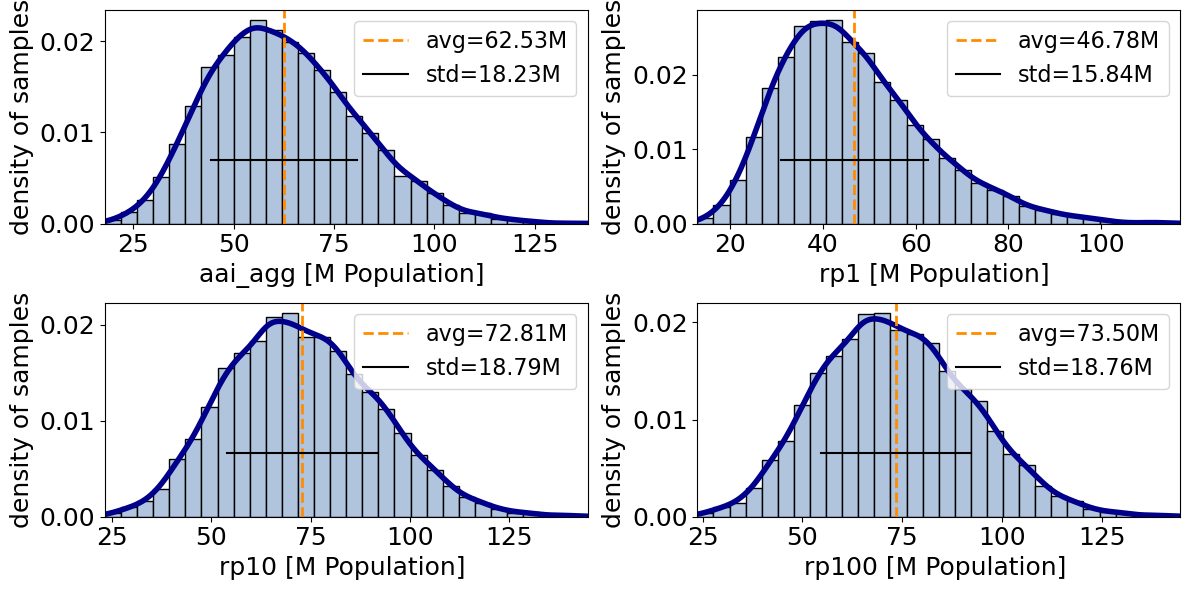

In [22]:
output_imp_non_linear.plot_uncertainty(figsize=(12, 6));

Here, the first graph (on the left) is a frequency graph illustrating the return period of heatwaves in relation to the affected population. The x-axis shows the impact of the affected population (in millions), while the y-axis indicates the return period in years. The graph shows three distributions in different colours, each representing different scenarios or conditions under which the impact assessments were conducted. For example, they could represent different climate models, uncertainty ranges or other variables that affect heat wave impacts.

The second graph (on the right) is a line depicting the population impact (in millions) for different heatwave return periods (in years). The lines represent different percentiles of impact: the solid line denotes the median (50th percentile), the upper dashed line is the 95th percentile, and the lower dashed line is the 5th percentile. This visualisation helps to understand the probability of heat waves occurring in the population. This plot helps to understand the likelihood and magnitude of extreme events, for example, how often severe heat waves could occur and how many people could be affected.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


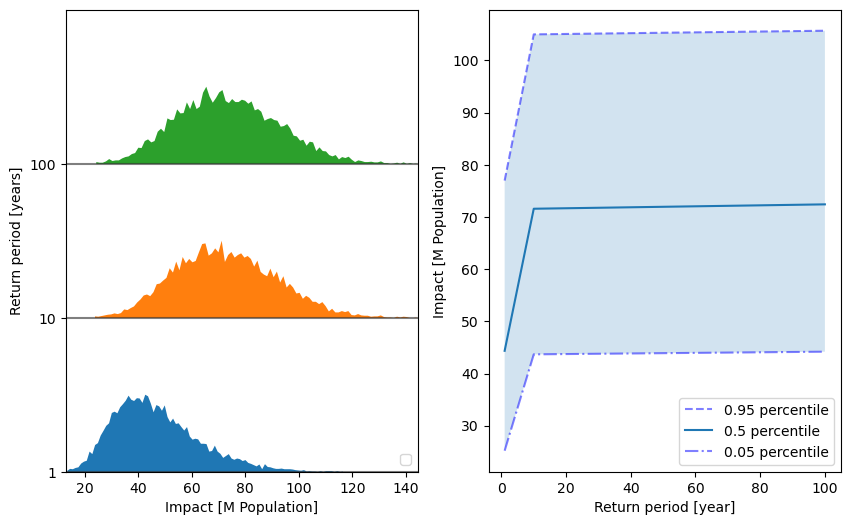

In [23]:
# Specific plot for the return period distributions
output_imp_non_linear.plot_rp_uncertainty(figsize=(10, 6));

### Explore Sensitivity
<a id="sensitivity-indices"></a>


We will now analyse the sensitivity of the parameters in the model. CLIMADA calculates first-order (S1) and second-order (S2) sensitivity indices, which help identify the most influential parameters and their interactions.

The results you've shown earlier (S1 sensitivity indices) indicate that:

- The exposure scaling factor (x_exp) is the most important parameter for most metrics, especially for higher return periods and individual events.
- The Mean Damage Degree (MDD) has a consistent, moderate influence across different metrics.
- The Impact Function intensity (IFi) is generally less important, especially for high-impact events and more extended return periods.

Exposure scaling directly affects the number of people potentially impacted, so its high importance makes sense. MDD determines how severely people are affected at different heat wave intensities, so its consistent moderate importance is reasonable. IFi's lower importance, especially for high-impact events, suggests that once heat waves reach a certain intensity (see the Impact Function with Uncertainties plot), further increases have diminishing effects on the overall impact.

In [24]:
output_imp_sensitivity = calc_imp.sensitivity(output_imp_non_linear)

output_imp_sensitivity.sensitivity_metrics

/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/daraya/miniforge3/envs/climada_env/lib/python3.9/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
 

['aai_agg', 'freq_curve', 'eai_exp', 'at_event']

The results from output_imp.get_sens_df('aai_agg').tail() indicate the second-order sensitivity indices (interaction effects) for the aai_agg metric, which stands for the average annual impact, often measured in terms of affected population or economic loss.
- **si**: Indicates the type of sensitivity index, here is predifined S2_conf, which represents the second-order confidence index. It quantifies the influence of an interaction between two parameters on the output variability.
- **param and param2**: These columns list the names of the input parameters being analyzed for interaction effects (MDD, IFi, x_exp).
- **aai_agg**: This column would contain the calculated second-order sensitivity index for the interaction of the parameters specified in the param and param2 columns concerning the average annual impact.
The NaN values denote that the sensitivity index could not be calculated for the interaction of those particular parameters. This might be due to insufficient or inconclusive data, or the model does not support calculating an interaction effect for those specific pairs of parameters.

The results showcase which parameter interactions have been calculated and their impact on the aai_aggmetric, for example, the interaction between IFi (intensity function) and MDD (mean damage degree). This value suggests a moderate level of influence of the interaction between these two parameters on the variability of the average annual impact, meaning changes in these two factors could lead to significant changes in this output.

In [25]:
output_imp_sensitivity.get_sens_df("aai_agg").tail()

,si,param,param2,aai_agg
25,S2_conf,IFi,IFi,NaN
26,S2_conf,IFi,MDD,0.063162
27,S2_conf,MDD,x_exp,NaN
28,S2_conf,MDD,IFi,NaN
29,S2_conf,MDD,MDD,NaN


The results from output_imp.get_sensitivity('S1') show the first-order sensitivity indices (S1) for different parameters with respect to various metrics. The first-order sensitivity index measures the direct effect of each input parameter on the output variability when varied on its own.
- **si**: Sensitivity index type, S1 indicates the first-order sensitivity index, can be change to S2.
- **param**: The input parameter being analyzed.
- **param2**: In this context, None signifies that the sensitivity index is calculated for a single parameter at a time without considering interactions with other parameters.
- **aai_agg, `rp1`, `rp10`,`rp100`**: The columns representing the average annual impact (aai_agg) and return periods (`rp1`, `rp10`,`rp100`) in millions of the affected population. The return period values represent the likelihood of a certain event happening within a given number of years.
The numerical values indicate how much these outputs are expected to change in response to changing each input parameter. A negative value implies that as the parameter increases, the impact metric decreases, which might suggest an inversely proportional relationship.

Here's a breakdown of the specific results:
S1 values:
- Values range from 0 to 1
- Higher values indicate greater importance of the parameter
- Values represent the fraction of output variance explained by each parameter individually

Key findings:
a) For aai_agg (Average Annual Impact):
- x_exp is most important (≈0.47)
- MDD is second (≈0.30)
- IFi is least important (≈0.20)

b) For different return periods:
- x_exp is most important for rp10 and rp100
- IFi is most important for rp1
- MDD has consistent importance across return periods

c) For individual events (columns 0-99):
- x_exp is consistently the most important parameter
- MDD is the second most important
- IFi is least important, with decreasing importance for higher-impact events

Overall conclusions:

- The exposure scaling factor (x_exp) is the most critical parameter for most metrics
- Mean Damage Degree (MDD) has a consistent, moderate influence
- Impact Function intensity (IFi) is generally less important, especially for high-impact events and more extended return periods

This analysis helps identify which parameters contribute most to the uncertainty in the model outputs, guiding where efforts should be focused to improve model accuracy and reduce uncertainty.

In [26]:
output_imp_sensitivity.get_sensitivity("S1")

,si,param,param2,aai_agg,rp1,rp10,rp100,0,1,2,...,90,91,92,93,94,95,96,97,98,99
0,S1,x_exp,None,0.472367,0.349669,0.604412,0.617506,0.565455,0.568723,0.568723,...,0.572350,0.578044,0.585368,0.593305,0.600533,0.605404,0.608553,0.611971,0.614878,0.617506
1,S1,IFi,None,0.200629,0.352267,0.060677,0.051483,0.111273,0.109114,0.109114,...,0.087091,0.082404,0.075950,0.069381,0.063679,0.059914,0.057924,0.055464,0.053276,0.051483
2,S1,MDD,None,0.300947,0.262717,0.312658,0.309428,0.303162,0.302318,0.302318,...,0.317030,0.316324,0.315681,0.314626,0.313390,0.312465,0.311560,0.310757,0.310123,0.309428


In [27]:
output_imp_sensitivity.get_largest_si(salib_si="S2")

/Users/daraya/Documents/climada_python/climada/engine/unsequa/unc_output.py:396: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_si_idx = si_df_num.idxmax().to_numpy()


,metric,param,param2,si
0,aai_agg,x_exp,MDD,0.011979
1,rp1,x_exp,IFi,0.015850
2,rp10,x_exp,MDD,0.014180
3,rp100,x_exp,MDD,0.013987
4,0,x_exp,MDD,0.012887
...,...,...,...,...
45862,95,x_exp,MDD,0.014173
45863,96,x_exp,MDD,0.014110
45864,97,x_exp,MDD,0.014073
45865,98,x_exp,MDD,0.014039


The sensitivity index "S1" reflects the effect of each input parameter when varied individually, without interaction with other parameters. Here is a breakdown of the graphs: On the left is a bar graph showing the sensitivity index (SI) for the input parameter 'aai_agg' (Average Annual Impact). The boxes represent the range of S1 index values for the parameters 'x_exp' (exposure scaling factor), 'IFi' (Impact Function intensity), and 'MDD' (Mean Damage Degree); the lines (whiskers) indicate the variability or uncertainty in these values. The further the box moves away from zero, the more influential that parameter is considered to be. On the right are three overlapping bar charts showing the sensitivity index (SI) for three return periods (`rp1`, `rp10`, and `rp100`). Each return period has its SI for the same input parameters: 'x_exp', 'IFi', and 'MDD'. These return periods correspond to events expected to occur once every 1, 10, and 100 years, respectively. 
- rp1 (Blue bars): The closer the bars are to zero, the less impact that parameter has on the output for this return period. A bar extending further from zero indicates a more substantial influence of that parameter on the 1-year return period events.

- rp10 (Orange bars): These bars correspond to events with a return period of 10 years. The sensitivity index for this more extended return period can show different magnitudes compared to the rp1, indicating that the impact of specific parameters might become more or less significant for less frequent events.
  
- rp100 (Green bars): These bars are associated with a return period of 100 years, representing rarer and potentially more severe events. The differences in bar heights across return periods can reveal how parameter importance shifts for increasingly extreme events. Generally, 'x_exp' tends to be the most influential parameter across all metrics, followed by 'MDD', while 'IFi' typically has the most negligible impact. However, the exact order and magnitude of influence can vary depending on the specific metric and return period being considered (see plot the Impact Function with Uncertainties).

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;Sampling processes, especially those that incorporate randomness or stochastic elements, can lead to slightly different estimates each time they are run. This variability is expected and is part of what makes each simulation unique. It's also why such processes are typically run multiple times to get a more robust understanding of the risks by looking at the spread or distribution of the results. </div>

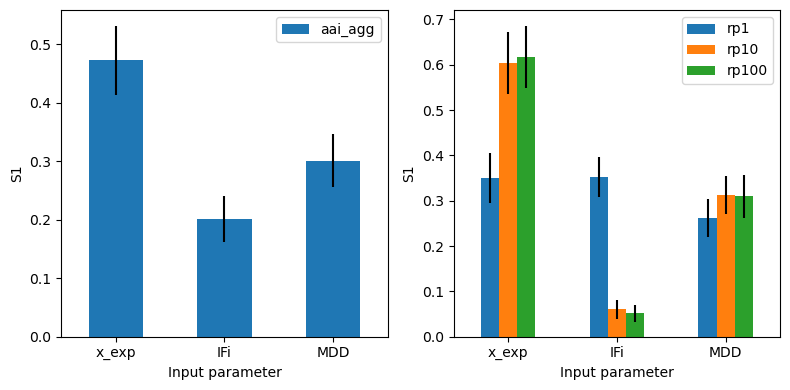

In [28]:
# Default for 'sobol' is to plot 'S1' sensitivity index.
output_imp_sensitivity.plot_sensitivity(salib_si="S1", figsize=(8, 4));

Here, we employ the total sensitivity index (ST) as a more comprehensive measure than the first-order sensitivity (S1). The ST index precisely quantifies the impact of each input parameter on the output variance, considering its individual effect and interaction with all other parameters.

The bars represent the ST index for different input parameters (such as x_exp, IFi, MDD) on the left and their impact on return periods (`rp1`, `rp10`, `rp100`) on the right. A higher ST value indicates that an input parameter has a more significant influence on the variance of the output. This includes not only the direct effect of changing that parameter but also how changes in that parameter interact with changes in other parameters. The vertical lines (or "whiskers") extending from the bars clearly indicate the range or uncertainty of the ST index estimate. A long whisker suggests more significant uncertainty is associated with the total sensitivity estimate for that parameter.

From this plot, one can deduce which parameters significantly impact the model results, including all interaction effects, and therefore, where to focus attention when considering model fits or robustness checks.

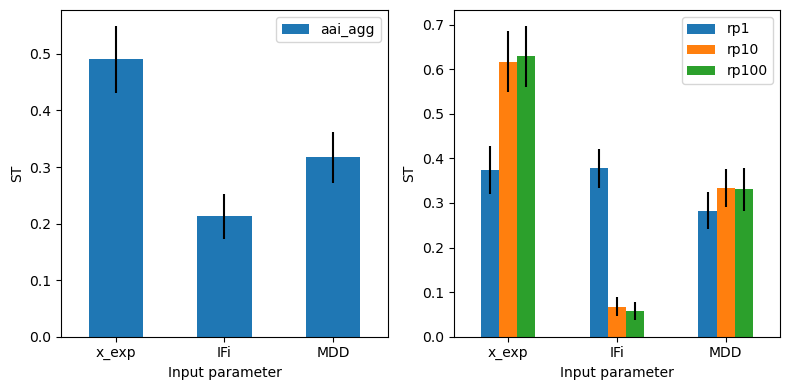

In [29]:
output_imp_sensitivity.plot_sensitivity(salib_si="ST", figsize=(8, 4));

Then, a second-order sensitivity (S2) analysis matrix for metrics such as aai_agg and return periods (`rp1`, `rp10`, `rp100`) is shown below. S2 indices measure how the interactions between pairs of input parameters influence the output variance.

Each cell in the matrix corresponds to the interaction between the input parameters along the row and column. The value inside each cell represents the S2 index for that particular pair of parameters. A higher value indicates a more substantial interaction effect on the output's variance. Then, the ± values represent the uncertainty or confidence intervals around the calculated S2 index. Cells with nan indicate that no interaction effect is measured, often because it refers to a parameter's interaction with itself, which is not defined in this context. The colours indicate the magnitude of the S2 indices, with different colours corresponding to various ranges of values. Darker or more intense colours represent higher values.

Analysis of these matrices allows us to understand not only the individual impact of each parameter on the outcome (as shown in the first-order sensitivities) but also how pairs of parameters work together to affect the outcome in complex models where interactions between factors are significant.

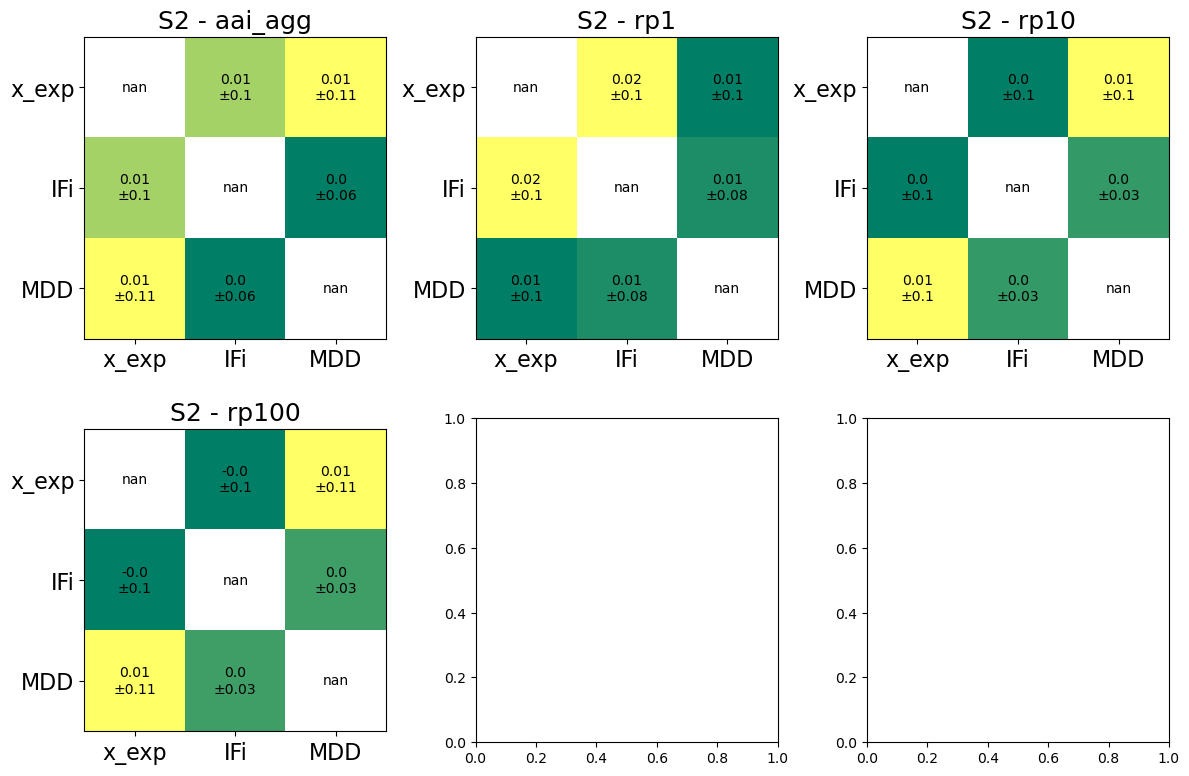

In [30]:
output_imp_sensitivity.plot_sensitivity_second_order(figsize=(12, 8));

The map below indicates the highest sensitivity index for each exposure location based on analysing the total impact, considering various uncertainties. The parameter "x_exp" has the highest first-order sensitivity index ("S1") for most of the exposure locations within the area shown. This means that the mean annual impact at these locations is most sensitive to changes or uncertainty in the "x_exp" parameter. "x_exp" represents a scaling factor for exposure, which adjusts how much the original values increase or decrease. Since "x_exp" is the most sensitive parameter across most locations, it implies that any variation in "x_exp" will have the most significant effect on the model results compared to other parameters such as "IFi" (Impact Function intensity) or "MDD" (Mean Damage Degree). This information can be beneficial when prioritizing which parameters to focus on in model calibration or risk mitigation strategies.

/Users/daraya/Documents/climada_python/climada/engine/unsequa/unc_output.py:396: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_si_idx = si_df_num.idxmax().to_numpy()


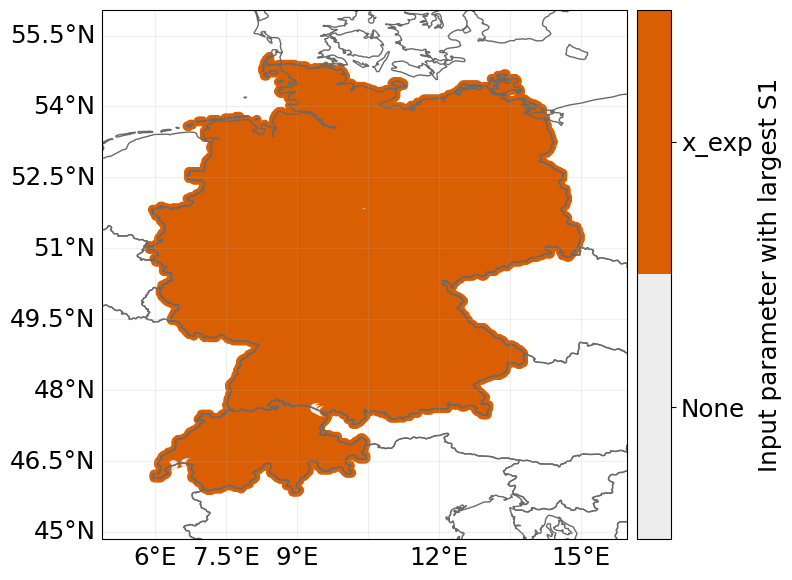

In [31]:
output_imp_sensitivity.plot_sensitivity_map();

### Comparing Deterministic Impact Values (original value of the impacts) with Uncertainty Analysis Outcomes in CLIMADA

Each plot compares the distribution of impact values obtained from the uncertainty analysis (blue bars and blue line for density) against the deterministic (original) values without considering uncertainty (green dotted lines). The orange dashed line represents the average value of the uncertain samples.

In the first plot for aai (top left), the average from uncertainty analysis is slightly lower than the original estimate. In the other three plots for return periods, the averages from the uncertainty analysis are either very close to or somewhat higher than the original estimates.

The standard deviation (std) values are minimal, indicating that while there's uncertainty in the data, the distributions are relatively tight around the mean. When the distribution of values is tight around the mean, it often indicates that the underlying model or system is relatively stable and consistent under the given set of uncertainties being considered. However, it's important to note that even with a tight distribution, uncertainty is still present. This means that although the majority of the sampled impacts fall near the mean value, the potential for impacts to deviate from this average still exists due to inherent variability.

In [41]:
from climada.engine import ImpactCalc
from climada.hazard import Hazard
from climada.entity import LitPop

# Load hazard data into CLIMADA Hazard object
hazard_equal_freq = Hazard.from_xarray_raster_file(
    f"{DATADIR}/HWD_EU_health_rcp85_mean_v1.0.nc",
    hazard_type="Heat_waves_days",
    intensity_unit="days",
    intensity="HWD_EU_health",
    coordinate_vars=dict(event="time", longitude="lon", latitude="lat"),
)
hazard_equal_freq.frequency = hazard_equal_freq.frequency / np.sum(hazard_equal_freq.frequency)
print("Sum of hazard frequencies:", np.sum(hazard_equal_freq.frequency))

# Load a default LitPop exposure entity for Switzerland and Germany in the year 2020 (ISO3-Codes 'CHE' and 'DEU'):
try:
    exposure = LitPop.from_countries(
        ["CHE", "DEU"], res_arcsec=120, fin_mode="pop", exponents=(2, 1)
    )
except FileExistsError as err:
    print(
        "Reason for error: The GPW population data has not been downloaded, c.f. section 'Input data' above."
    )
    raise err

# Method assigns the centroids of hazard events to the exposure data. This step allows for the association of hazard events with specific population locations.
exposure.assign_centroids(hazard_equal_freq)

# Calculate impact using the ImpactCalc class
imp = ImpactCalc(exposure, if_set_base, hazard_equal_freq).impact(save_mat=True)
aai_agg_o = imp.aai_agg
freq_curve_o = imp.calc_freq_curve([1, 10, 100]).impact
orig_list = [aai_agg_o] + list(freq_curve_o) + [1]

print(f"Average Annual Impact: {aai_agg_o}")
print(f"Frequency curve at return periods [1, 10, 100]: {freq_curve_o}")

Sum of hazard frequencies: 0.9999999999999999
2024-08-24 22:39:27,597 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 22:39:27,606 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 22:39:27,621 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 22:39:27,634 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 22:39:27,641 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 22:39:27,653 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-24 22:39:27,666 

In [45]:
rps = [1, 10, 100]
intensities = hazard_equal_freq.local_exceedance_inten(rps)
print("\nAdjusted Return Period Hazard Intensities:")
for rp, intensity in zip(rps, intensities):
    print(f"RP {rp} years: Mean = {np.mean(intensity):.2f} days, Max = {np.max(intensity):.2f} days")




Adjusted Return Period Hazard Intensities:
RP 1 years: Mean = 4.29 days, Max = 24.31 days
RP 10 years: Mean = 14.17 days, Max = 74.95 days
RP 100 years: Mean = 24.05 days, Max = 125.60 days


In [46]:
print(if_set_base.get_func())


{'Heat_waves_days': {1: <climada.entity.impact_funcs.base.ImpactFunc object at 0x30eed83a0>}}


In [47]:
print(hazard_equal_freq.intensity.min(), hazard_equal_freq.intensity.max())


0.0 83.17239


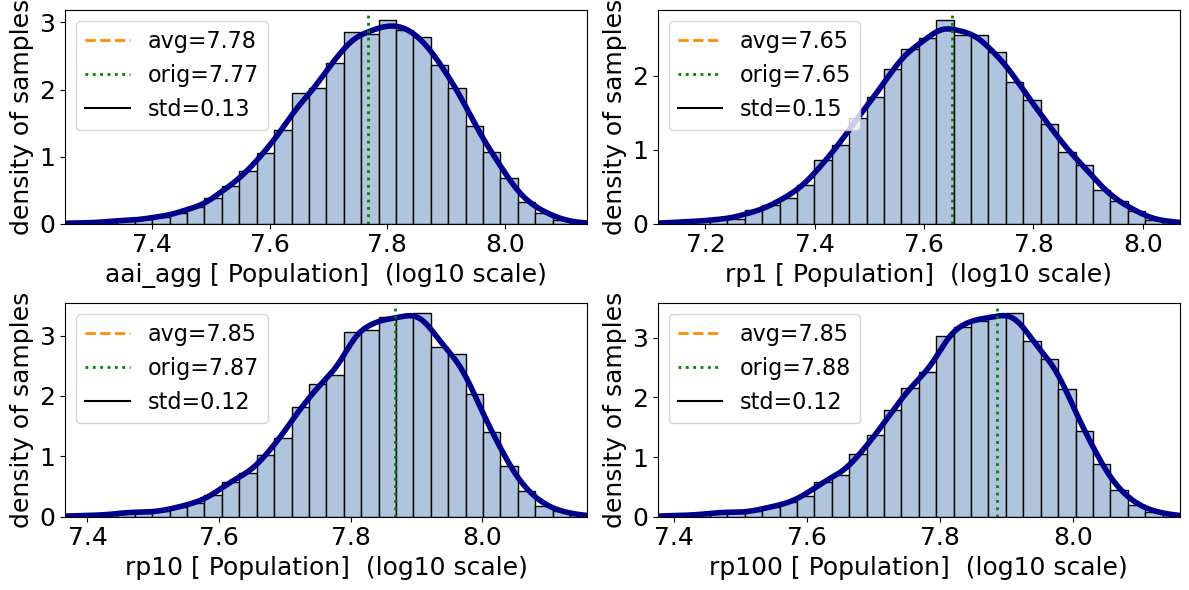

In [48]:
# plot the aai_agg and freq_curve uncertainty only
# use logarithmic x-scale
output_imp_non_linear.plot_uncertainty(
    metric_list=["aai_agg", "freq_curve"],
    orig_list=orig_list,
    log=True,
    figsize=(12, 6),
);

# Resume

The results generated in the sensitivity analysis section provide valuable insights into the drivers of uncertainty in the model. By focusing on the sensitivity indices (S1, ST) and frequency curves, we can identify which variables are the most significant contributors to the variability in your results. Here’s how to interpret these outputs, referring to the specific results obtained from the CLIMADA tutorial:

- [Sensitivity Indices (S1 and ST)](#sensitivity-indices)<a id="sensitivity-indices"></a>: In the results, the S1 sensitivity index identifies how much each input variable contributes to the variance in the output when varied independently. At the same time, ST captures both direct and interaction effects between variables, for instance, in output_imp_sensitivity.get_sensitivity("S1"), the exposure scaling factor (x_exp) has an S1 index of approximately 0.47, making it the most influential parameter on the aggregated annual impact (AAI). This suggests that the model is susceptible to changes in exposure data, implying that more precise data on population or asset distribution could significantly reduce overall uncertainty. Conversely, the Impact Function Intensity (IFi) has an S1 index of 0.20, indicating a moderate influence. The low value means refining this variable might not significantly impact the results. The ST index values show that the total sensitivity index for exposure scaling (x_exp) is higher for RP100 events than RP1, which means that the model’s uncertainty increases with extreme events, highlighting the need for better exposure data for long-term risk assessment.

- [Return Periods and Aggregated Annual Impact (aai)](#output-return-periods-and-aggregated-annual-impact-aai)<a id="#output-return-periods-and-aggregated-annual-impact-aai"></a>: The results for return periods, particularly the RP1, RP10, and RP100, indicate how the model's outputs vary across different timeframes. The aai shows a mean of ≈63 million people affected by heatwaves, with a standard deviation of ≈±18 million. This significant variability highlights the uncertainty in predicting the exact impact of future heatwaves, which can guide decision-makers toward adopting robust policies that accommodate a wide range of possible outcomes. For RP10 events, the uncertainty is more significant, with a standard deviation of ≈ 19 million people affected, suggesting that more frequent extreme events introduce higher unpredictability in model outcomes. This variability indicates where adaptation strategies need to be most flexible.

- Implications for Policy and Data Collection: These results suggest that exposure scaling (x_exp) is the most sensitive parameter and thus should be prioritized for refinement. Policymakers could use this information to focus resources on improving exposure data, as this has the most significant impact on reducing uncertainty in heatwave risk assessments. Additionally, IFi plays a smaller role in most scenarios; its contribution to uncertainty increases in lower-impact events like RP1. This suggests that further investigation into the impact function intensity is warranted for frequent, lower-risk heatwave events, especially in regions where vulnerability might be underestimated.



